In [1]:
#import libraries
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# models
import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from sklearn.utils import resample
import scipy.stats as stats

/Users/renormalization/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Table of Contents

1. [Problem](#Problem)
2. [Data](#Data)
3. [EDA](#EDA)
4. [Model](#Model)
5. [Output](#Output)


<a id='Problem'></a>
# Problem

https://www.kaggle.com/c/demand-forecasting-kernels-only/data

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores. What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

Evaluation is based on Symmetric mean absolute percentage error

Data
- Date of the sale data. There are no holiday effects or store closures.
- Store ID
- Item ID
- Number of items sold at a particular store on a particular date.

<a id='Data'></a>
# Data

In [2]:
!ls

Data                 Plot
KaggleTemplate.ipynb Version0.ipynb


In [3]:
## load the csv files, small
train = pd.read_csv('Data/train.csv', parse_dates=['date'], index_col=['date'])
test  = pd.read_csv('Data/test.csv', parse_dates=['date'], index_col=['date'])
sample = pd.read_csv('Data/sample_submission.csv')

In [4]:
sample.head()

id  sales
0   0     52
1   1     52
2   2     52
3   3     52
4   4     52

There are 10 different stores and 50 different items

In [5]:
train.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [6]:
test.describe()

id         store         item
count  45000.000000  45000.000000  45000.00000
mean   22499.500000      5.500000     25.50000
std    12990.525394      2.872313     14.43103
min        0.000000      1.000000      1.00000
25%    11249.750000      3.000000     13.00000
50%    22499.500000      5.500000     25.50000
75%    33749.250000      8.000000     38.00000
max    44999.000000     10.000000     50.00000

In [7]:
sample.describe()

id    sales
count  45000.000000  45000.0
mean   22499.500000     52.0
std    12990.525394      0.0
min        0.000000     52.0
25%    11249.750000     52.0
50%    22499.500000     52.0
75%    33749.250000     52.0
max    44999.000000     52.0

<a id='EDA'></a>
# EDA

In [8]:
train['store'].nunique()

10

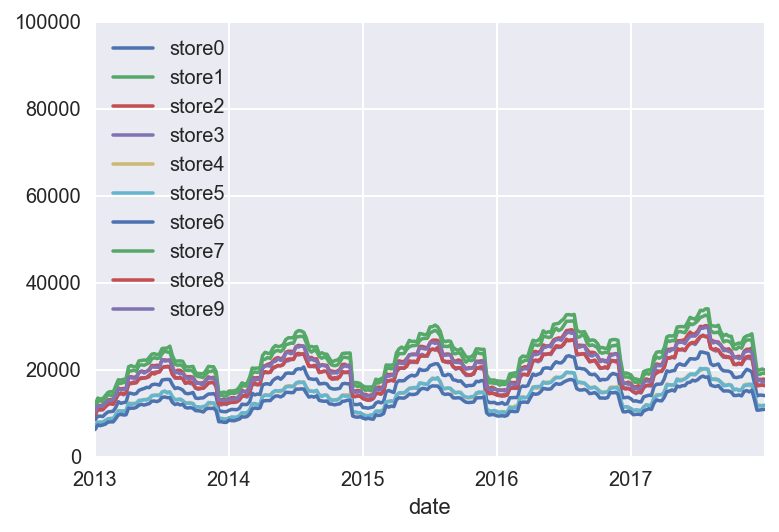

In [9]:
#### Seasonality Check
# preparation: input should be float type
train['sales'] = train['sales'] * 1.0

# specify the number of stores
n_store = train['store'].nunique()
plt.clf()
#f, axes = plt.subplots(n_store, figsize = (12, 13))
# store types
for i in range(n_store):
    #print(i)
    sales_a = train.loc[train['store'] == (i+1)]['sales'].sort_index(ascending = True)
    sales_a.resample('W').sum().plot(label=('store' + str(i)))

plt.ylim(0, 100000)
# show the plot
plt.legend()
plt.show()

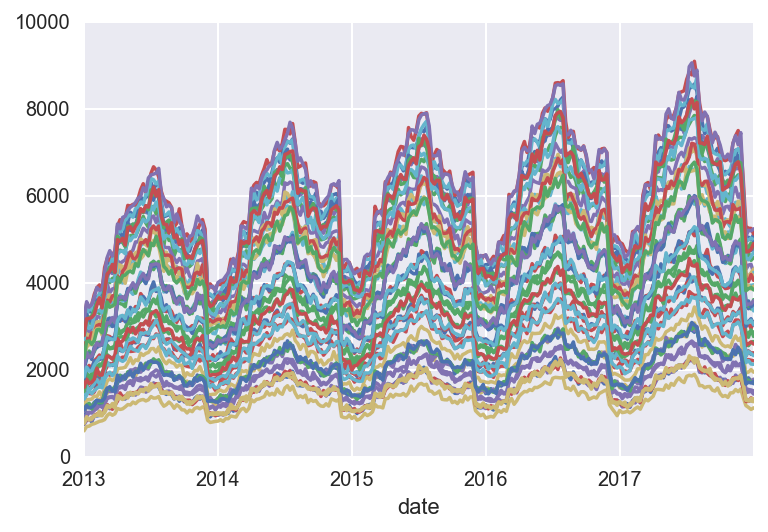

In [10]:
#### Item Check
# preparation: input should be float type
train['sales'] = train['sales'] * 1.0

# specify the number of stores
n_item = train['item'].nunique()
plt.clf()
#f, axes = plt.subplots(n_store, figsize = (12, 13))
# store types
for i in range(n_item):
    #print(i)
    sales_a = train.loc[train['item'] == (i+1)]['sales'].sort_index(ascending = True)
    sales_a.resample('W').sum().plot(label=('store' + str(i)))

plt.ylim(0, 10000)
# show the plot
#plt.legend()
plt.show()

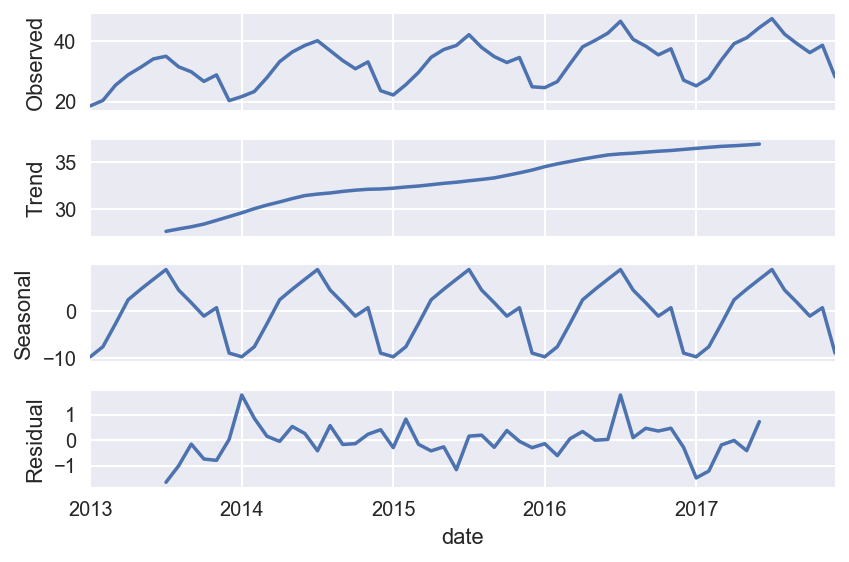

In [11]:
y = train.loc[train['item'] == 17]['sales'].resample('MS').mean()
# y.plot()
# plt.show()
## additive is more transparent
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

There are clear seasonal and linear trends

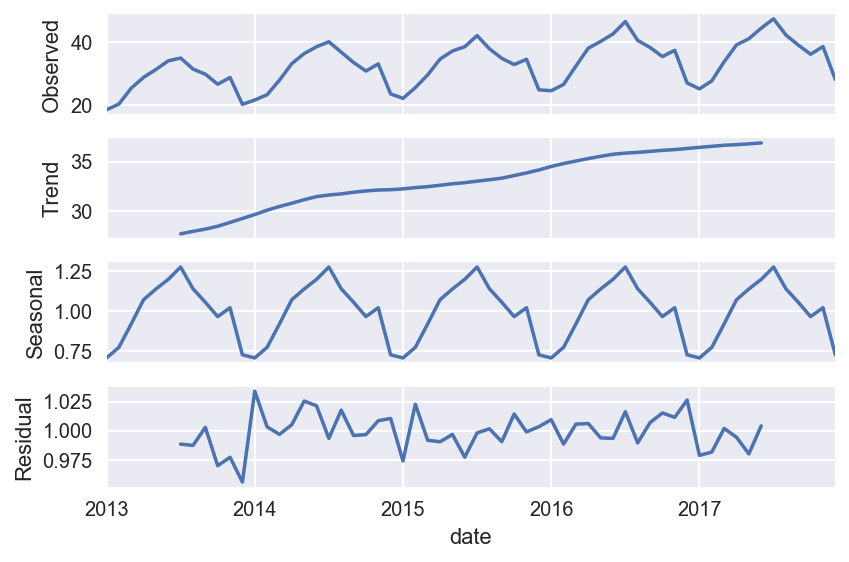

In [12]:
## see: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();

In [13]:
decomposition.trend.values

array([         nan,          nan,          nan,          nan,
                nan,          nan,  27.69414491,  27.94515297,
        28.17277394,  28.45803379,  28.84840118,  29.24390745,
        29.64411802,  30.08175243,  30.45945405,  30.78769329,
        31.1402381 ,  31.45622376,  31.61563236,  31.731843  ,
        31.89603751,  32.02647209,  32.12048195,  32.15407514,
        32.23605543,  32.3622651 ,  32.46080005,  32.60140489,
        32.74784306,  32.86188876,  33.01618984,  33.15882103,
        33.31771567,  33.57854004,  33.84877302,  34.14400599,
        34.49784112,  34.79380886,  35.04858037,  35.2975723 ,
        35.52225868,  35.73269775,  35.84842356,  35.92063011,
        36.02428827,  36.12435996,  36.20373272,  36.31574437,
        36.42815924,  36.53568612,  36.63899258,  36.7013044 ,
        36.78097734,  36.87597286,          nan,          nan,
                nan,          nan,          nan,          nan])

<a id='Model'></a>
# Model

In [14]:
## Setup train and validation; 
mytrain = train.loc[(train.index < '2017-01-01')]
myval   = train.loc[(train.index >= '2017-01-01')]

In [15]:
## currently it is a 3:1 split
print(mytrain.shape, myval.shape, myval.shape[0]/mytrain.shape[0])

(730500, 3) (182500, 3) 0.24982888432580425


## Go down the stupid Machine learning way

In [16]:
## merge dataframe
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
df = pd.concat([train,test])
print('Combined df shape:{}'.format(df.shape))

Combined df shape:(958000, 5)


In [17]:
df['dayofmonth'] = df.index.day
df['dayofyear']  = df.index.dayofyear
df['dayofweek']  = df.index.dayofweek
df['month']      = df.index.month
df['year']       = df.index.year
df['weekofyear'] = df.index.weekofyear
df['is_month_start'] = (df.index.is_month_start).astype(int)
df['is_month_end'] = (df.index.is_month_end).astype(int)
#df.head(n=20)

In [18]:
# Sorting the dataframe by store then item then date
df.sort_values(by=['store','item'], axis=0, inplace=True)

In [19]:
df.head()

id  item  sales  store train_or_test  dayofmonth  dayofyear  \
date                                                                      
2013-01-01 NaN     1   13.0      1         train           1          1   
2013-01-02 NaN     1   11.0      1         train           2          2   
2013-01-03 NaN     1   14.0      1         train           3          3   
2013-01-04 NaN     1   13.0      1         train           4          4   
2013-01-05 NaN     1   10.0      1         train           5          5   

            dayofweek  month  year  weekofyear  is_month_start  is_month_end  
date                                                                          
2013-01-01          1      1  2013           1               1             0  
2013-01-02          2      1  2013           1               0             0  
2013-01-03          3      1  2013           1               0             0  
2013-01-04          4      1  2013           1               0             0  
2013-01-05          5      1  2013           1               0             0

In [20]:
df["mean-store_item"]   = df.groupby(["item", "store"])["sales"].transform("mean")
df["mean-month_item"]   = df.groupby(["month", "item"])["sales"].transform("mean")
df["mean-item"]         = df.groupby(["item"])["sales"].transform("mean")
df["mean-store"]        = df.groupby(["store"])["sales"].transform("mean")
df["mean-store_item-week"] = df.groupby(["item", "store",'weekofyear'])["sales"].transform("mean")
df["mean-store-month"]  = df.groupby(['month', "store"])["sales"].transform("mean")

df["std-store_item"]   = df.groupby(["item", "store"])["sales"].transform("std")
df["std-month_item"]   = df.groupby(["month", "item"])["sales"].transform("std")
df["std-item"] = df.groupby(["item"])["sales"].transform("std")
df["std-store"] = df.groupby(["store"])["sales"].transform("std")

df["median-store_item"]  = df.groupby(["item", "store"])["sales"].transform("median")
df["median-month_item"]  = df.groupby(["month", "item"])["sales"].transform("median")
df["median-month_store"] = df.groupby(["month", "store"])["sales"].transform("median")
df["median-item"]        = df.groupby(["item"])["sales"].transform("median")
df["median-store"]       = df.groupby(["store"])["sales"].transform("median")
df["median-store_item-month"] = df.groupby(['month', "item", "store"])["sales"].transform("median")

# adding more lags (Check the rationale behind this in the links attached)
lags = [90,91,98,105,112,119,126,182,189,364]
for i in tqdm(lags):
#     print("Done For Lag {}".format(i))
    df['_'.join(['item-week_shifted-', str(i)])] = df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).sum()) 
    df['_'.join(['item-week_shifted-', str(i)])] = df.groupby(['weekofyear',"item"])["sales"].transform(lambda x:x.shift(i).mean()) 
    df['_'.join(['item-week_shifted-', str(i)])].fillna(df['_'.join(['item-week_shifted-', str(i)])].mode()[0], inplace=True)
    ##### sales for that item i days in the past
    df['_'.join(['store-week_shifted-', str(i)])] = df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).sum())
    df['_'.join(['store-week_shifted-', str(i)])] = df.groupby(['weekofyear',"store"])["sales"].transform(lambda x:x.shift(i).mean()) 
    df['_'.join(['store-week_shifted-', str(i)])].fillna(df['_'.join(['store-week_shifted-', str(i)])].mode()[0], inplace=True)

100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


In [21]:
df.head()

id  item  sales  store train_or_test  dayofmonth  dayofyear  \
date                                                                      
2013-01-01 NaN     1   13.0      1         train           1          1   
2013-01-02 NaN     1   11.0      1         train           2          2   
2013-01-03 NaN     1   14.0      1         train           3          3   
2013-01-04 NaN     1   13.0      1         train           4          4   
2013-01-05 NaN     1   10.0      1         train           5          5   

            dayofweek  month  year           ...             \
date                                         ...              
2013-01-01          1      1  2013           ...              
2013-01-02          2      1  2013           ...              
2013-01-03          3      1  2013           ...              
2013-01-04          4      1  2013           ...              
2013-01-05          5      1  2013           ...              

            item-week_shifted-_119  store-week_shifted-_119  \
date                                                          
2013-01-01               14.070248                32.657303   
2013-01-02               14.070248                32.657303   
2013-01-03               14.070248                32.657303   
2013-01-04               14.070248                32.657303   
2013-01-05               14.070248                32.657303   

            item-week_shifted-_126  store-week_shifted-_126  \
date                                                          
2013-01-01               14.058824                32.677722   
2013-01-02               14.058824                32.677722   
2013-01-03               14.058824                32.677722   
2013-01-04               14.058824                32.677722   
2013-01-05               14.058824                32.677722   

            item-week_shifted-_182  store-week_shifted-_182  \
date                                                          
2013-01-01               15.046632                33.028332   
2013-01-02               15.046632                33.028332   
2013-01-03               15.046632                33.028332   
2013-01-04               15.046632                33.028332   
2013-01-05               15.046632                33.028332   

            item-week_shifted-_189  store-week_shifted-_189  \
date                                                          
2013-01-01               15.155914                33.018758   
2013-01-02               15.155914                33.018758   
2013-01-03               15.155914                33.018758   
2013-01-04               15.155914                33.018758   
2013-01-05               15.155914                33.018758   

            item-week_shifted-_364  store-week_shifted-_364  
date                                                         
2013-01-01               14.230769                33.165833  
2013-01-02               14.230769                33.165833  
2013-01-03               14.230769                33.165833  
2013-01-04               14.230769                33.165833  
2013-01-05               14.230769                33.165833  

[5 rows x 49 columns]

In [22]:
train = df.loc[~df["sales"].isnull()]
print("new train",train.shape)
test = df.loc[df.sales.isnull()]
print("new test",test.shape)

new train (913000, 49)
new test (45000, 49)


In [23]:
avoid_cols = ['sales', 'id', 'year', 'train_or_test']
cols = [col for col in train.columns if col not in avoid_cols]
print('No of training features: {} \nAnd they are:{}'.format(len(cols), cols))

No of training features: 45 
And they are:['item', 'store', 'dayofmonth', 'dayofyear', 'dayofweek', 'month', 'weekofyear', 'is_month_start', 'is_month_end', 'mean-store_item', 'mean-month_item', 'mean-item', 'mean-store', 'mean-store_item-week', 'mean-store-month', 'std-store_item', 'std-month_item', 'std-item', 'std-store', 'median-store_item', 'median-month_item', 'median-month_store', 'median-item', 'median-store', 'median-store_item-month', 'item-week_shifted-_90', 'store-week_shifted-_90', 'item-week_shifted-_91', 'store-week_shifted-_91', 'item-week_shifted-_98', 'store-week_shifted-_98', 'item-week_shifted-_105', 'store-week_shifted-_105', 'item-week_shifted-_112', 'store-week_shifted-_112', 'item-week_shifted-_119', 'store-week_shifted-_119', 'item-week_shifted-_126', 'store-week_shifted-_126', 'item-week_shifted-_182', 'store-week_shifted-_182', 'item-week_shifted-_189', 'store-week_shifted-_189', 'item-week_shifted-_364', 'store-week_shifted-_364']


In [24]:
def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [26]:
# create validation
masked_series = (df.year==2017) & (df.month.isin([1,2,3]))
masked_series2 = (df.year==2017) & (~(df.month.isin([1,2,3])))
df.loc[(masked_series), 'train_or_test'] = 'val'
df.loc[(masked_series2), 'train_or_test'] = 'no_train'
print('Train shape: {}'.format(df.loc[df.train_or_test=='train',:].shape))
print('Validation shape: {}'.format(df.loc[df.train_or_test=='val',:].shape))
print('No train shape: {}'.format(df.loc[df.train_or_test=='no_train',:].shape))
print('Test shape: {}'.format(df.loc[df.train_or_test=='test',:].shape))

Train shape: (730500, 49)
Validation shape: (45000, 49)
No train shape: (137500, 49)
Test shape: (45000, 49)


In [40]:
# Final train and val datasets
val = df.loc[df.train_or_test=='val']
train = df.loc[df.train_or_test=='train']
Y_val = df.loc[df.train_or_test=='val']['sales'].values
Y_train = df.loc[df.train_or_test=='train']['sales'].values
print('Train shape:{}, Val shape:{}'.format(train.shape, val.shape))
print('Y Train shape:{}, Val shape:{}'.format(Y_train.shape, Y_val.shape))

Train shape:(730500, 49), Val shape:(45000, 49)
Y Train shape:(730500,), Val shape:(45000,)


In [41]:
# Creating lgbtrain & lgbval
lgbtrain = lgb.Dataset(data=train.loc[:,cols].values, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=val.loc[:,cols].values, label=Y_val, reference=lgbtrain, feature_name=cols)

In [45]:
# LightGBM parameters
lgb_params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': 'mape', 'num_leaves': 200, 'learning_rate': 0.005, 
              'feature_fraction': 0.8, 'max_depth': 6, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':50, 'nthread':4}

In [46]:
def lgb_validation(params, lgbtrain, lgbval, X_val, Y_val, verbose_eval):
    t0 = time.time()
    evals_result = {}
    model = lgb.train(params, lgbtrain, valid_sets=[lgbtrain, lgbval], evals_result=evals_result, verbose_eval=verbose_eval)
    print(model.best_iteration)
    print('Total time taken to build the model: ', (time.time()-t0)/60, 'minutes!!')
    pred_Y_val = model.predict(X_val, num_iteration=model.best_iteration)
    pred_Y_val = np.expm1(pred_Y_val)
    Y_val = np.expm1(Y_val)
    val_df = pd.DataFrame(columns=['true_Y_val','pred_Y_val'])
    val_df['pred_Y_val'] = pred_Y_val
    val_df['true_Y_val'] = Y_val
    print(val_df.shape)
    print(val_df.sample(5))
    print('SMAPE for validation data is:{}'.format(smape(pred_Y_val, Y_val)))
    return model, val_df

In [47]:
# Training lightgbm model and validating
model, val_df = lgb_validation(lgb_params, lgbtrain, lgbval, val.loc[:,cols].values, Y_val, verbose_eval=200)

/Users/renormalization/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/renormalization/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[200]	training's mape: 0.305144	valid_1's mape: 0.292392
[400]	training's mape: 0.19407	valid_1's mape: 0.17865
[600]	training's mape: 0.166806	valid_1's mape: 0.163452
Early stopping, best iteration is:
[633]	training's mape: 0.165013	valid_1's mape: 0.163328
633
Total time taken to build the model:  0.718634299437205 minutes!!
(45000, 2)
         true_Y_val    pred_Y_val
7415   3.637971e+42  7.484084e+32
1893   4.727839e+18  6.428227e+18
458    2.353853e+17  8.544594e+12
29585  3.831008e+22  2.290174e+17
44391  5.320482e+11  3.379157e+11
SMAPE for validation data is:172.5608335614457


In [48]:
# Let's see top 25 features as identified by the lightgbm model.
print("Features importance...")
gain = model.feature_importance('gain')
feat_imp = pd.DataFrame({'feature':model.feature_name(), 
                         'split':model.feature_importance('split'), 
                         'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print('Top 25 features:\n', feat_imp.head(25))

Features importance...
Top 25 features:
                     feature       gain  split
24  median-store_item-month  67.323753  10446
13     mean-store_item-week  23.332747   9724
4                 dayofweek   7.040819  12360
9           mean-store_item   1.567472    170
10          mean-month_item   0.379103    363
14         mean-store-month   0.096327    308
19        median-store_item   0.082902     30
16           std-month_item   0.055249    147
20        median-month_item   0.032739     96
3                 dayofyear   0.029974   3527
15           std-store_item   0.016999     93
21       median-month_store   0.011637     67
6                weekofyear   0.008926    592
2                dayofmonth   0.007058    760
12               mean-store   0.004896     55
18                std-store   0.001841     10
41   item-week_shifted-_189   0.000948     84
39   item-week_shifted-_182   0.000857     75
5                     month   0.000849    101
37   item-week_shifted-_126   0.000672 

In [50]:
# Final train and test datasets
test = df.loc[df.train_or_test=='test', :]
train = df.loc[~(df.train_or_test=='test'), :]
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))

Train shape:(913000, 49), Test shape:(45000, 49)


In [51]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=train.loc[:,cols].values, 
                           label=train.loc[:,'sales'].values.reshape((-1,)), 
                           feature_name=cols)

def lgb_train(params, lgbtrain_all, X_test, num_round):
    t0 = time.time()
    model = lgb.train(params, lgbtrain_all, num_boost_round=num_round, feval=lgbm_smape)
    test_preds = model.predict(X_test, num_iteration=num_round)
    print('Total time taken in model training: ', (time.time()-t0)/60, 'minutes!')
    return model, test_preds

In [52]:
# Training lgb model on whole data(train+val)
lgb_model, test_preds = lgb_train(lgb_params, lgbtrain_all, test.loc[:,cols].values, model.best_iteration)
print('test_preds shape:{}'.format(test_preds.shape))

Total time taken in model training:  0.949781334400177 minutes!
test_preds shape:(45000,)


<a id='Output'></a>
# Output

In [53]:
# Create submission
sub = test.loc[:,['id','sales']]
sub['sales'] = np.expm1(test_preds)
sub['id'] = sub.id.astype(int)
sub.to_csv('submission.csv', index=False)
sub.head()

id         sales
date                        
2018-01-01   0  3.975746e+05
2018-01-02   1  1.479370e+06
2018-01-03   2  1.508960e+06
2018-01-04   3  3.396745e+06
2018-01-05   4  8.531844e+06

In [60]:
!kaggle competitions submit -c demand-forecasting-kernels-only -f submission.csv -m "Message"

Traceback (most recent call last):
  File "/Users/renormalization/anaconda/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/Users/renormalization/anaconda/lib/python3.6/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/renormalization/anaconda/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 109, in authenticate
    self._load_config(config_data)
  File "/Users/renormalization/anaconda/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 151, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
